In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm import tqdm
import random
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
from preprocessing import *

In [3]:
from mimic_diagnoses import *

In [ ]:
#Get raw Time Series
patients = pd.read_csv('mimic_data/PATIENTS.csv')
admissions = pd.read_csv('mimic_data/ADMISSIONS.csv')
diagnoses = pd.read_csv('mimic_data/DIAGNOSES_ICD.csv')
admissions_leadii, patients_leadii, diagnoses_leadii = mimic_diagnoses.get_leadii_dataframes(patients, admissions, diagnoses)
mimic_diagnoses.add_icd_10_code_to_diagnoses(diagnoses_leadii)
data = get_aligned_ss_and_bp(admissions_leadii)

/Users/luismendoza/Desktop/CS/HMC CS/Clinic/EIT-Clinic-Waveform/sleep/risk_classification/mimic_diagnoses.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnoses['ICD10_CODE'] = diagnoses.ICD9_CODE.apply(lambda x: icd_9_to_10_from_code(x, icd_9_to_10_d))


Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE',
       'ICD10_CODE'],
      dtype='object')


In [ ]:
#Threshold for Binary Classification
class_threshold = 0.5

In [ ]:
patient_ids = [tup[0] for tup in list(data.keys())]
start_before_sleep_arrays = [get_start_before_sleep(bp_ss) for bp_ss in list(data.values())]

/Users/luismendoza/Desktop/CS/HMC CS/Clinic/EIT-Clinic-Waveform/sleep/risk_classification/preprocessing.py:209: RuntimeWarning: invalid value encountered in scalar divide
  if np.sum(ss[sleep_start:end] == 3) / len(ss[sleep_start:end]) >= 0.5:


starting features


In [ ]:
features = get_time_series_features(patient_ids, start_before_sleep_arrays, True, 8, 8, diagnoses_leadii)

In [ ]:
#Grab labels and separate dataset into training and validation sets
labels = features[1]
data_list = list(features[0])

data_length = len(data_list)
train_size = int(data_length * 0.8)
val_size = data_length - train_size

print(len(labels))
print(len(data_list))
ones = sum(labels)
print(ones)

for i in range(len(labels)):
    data_list[i] = [labels[i], data_list[i]]

random.shuffle(data_list)

train_list = data_list[:train_size]
val_list = data_list[train_size:]

90
90
43


In [45]:
def preprocess_dataset(dataset, normalize_sleep=True):
    """
    Converts dataset into CNN-ready tensors by padding/truncating time series.

    Args:
        dataset: list of [label, np.array([dis, sys, ss])]
        normalize_sleep: whether to normalize sleep stages
        target_length: fixed sequence length

    Returns:
        X_tensor: torch.FloatTensor (batch, 3, target_length)
        y_tensor: torch.FloatTensor (batch,)
    """
    X_series = []
    Y = []

    for label, data in dataset:
        dis = data[0]
        sys = data[1]
        ss = data[2]
        
        dis = (dis - dis.mean()) / dis.std()
        sys = (sys - sys.mean()) / sys.std()
        ss = (ss -ss.mean()) / ss.std()
        print(f"dis:{dis}")
        print(f"sys: {sys}")
        print(f"ss: {ss}")


        

        signal = np.stack([dis, sys, ss])
        X_series.append(signal)
        Y.append(label)
    
    np.array(X_series)

    X_tensor = torch.tensor(X_series, dtype=torch.float32)
    y_tensor = torch.tensor(np.array(Y), dtype=torch.float32)

    return X_tensor, y_tensor


In [46]:
X_train, y_train = preprocess_dataset(train_list)
X_val, y_val = preprocess_dataset(val_list)

dis:[ 0.84380571  1.08014517  0.84380571  0.92258553  0.52868644  0.52868644
  0.60746626  0.52868644  0.44990662  0.52868644  0.68624608  0.29234698
  0.29234698  0.13478735 -0.02277229  0.29234698  0.29234698  0.05600753
  0.29234698 -0.02277229  0.29234698 -0.02277229  0.13478735  0.21356716
 -0.18033193 -0.10155211 -0.25911175 -0.25911175  0.29234698  0.52868644
  0.3711268   1.00136535  0.44990662  0.60746626  0.21356716  0.05600753
  0.21356716 -0.10155211 -0.33789157 -0.33789157 -0.10155211  0.17417725
 -0.57423102  0.05600753 -0.0621622  -0.65301084 -0.25911175 -0.10155211
 -0.02277229 -0.33789157 -0.33789157 -0.33789157 -0.4954512  -0.41667138
 -0.29850166 -0.4954512  -0.65301084 -1.04690993 -0.81057048 -0.65301084
 -0.88935029 -0.02277229 -0.25911175 -0.73179066 -0.33789157 -1.04690993
 -0.81057048 -1.04690993 -1.16507966 -0.65301084 -0.73179066 -1.28324939
 -0.65301084 -0.73179066 -1.08629984 -0.4954512  -0.88935029 -1.51958884
 -0.81057048 -1.04690993 -1.04690993 -1.0469099

ss: [ 1.00836835  1.00836835  1.00836835  1.00836835  1.00836835  1.00836835
  1.00836835  1.00836835  1.00836835  1.00836835  1.00836835  1.00836835
  1.00836835  1.00836835  1.00836835 -0.9917011  -0.9917011  -0.9917011
 -0.9917011  -0.9917011  -0.9917011  -0.9917011  -0.9917011  -0.9917011
 -0.9917011  -0.9917011  -0.9917011  -0.9917011  -0.9917011  -0.9917011
 -0.9917011  -0.9917011  -0.9917011  -0.9917011  -0.9917011  -0.9917011
 -0.9917011  -0.9917011  -0.9917011   1.00836835  1.00836835  1.00836835
  1.00836835  1.00836835  1.00836835  1.00836835  1.00836835  1.00836835
  1.00836835  1.00836835  1.00836835  1.00836835  1.00836835  1.00836835
  1.00836835  1.00836835  1.00836835  1.00836835  1.00836835  1.00836835
  1.00836835  1.00836835  1.00836835  1.00836835  1.00836835  1.00836835
  1.00836835  1.00836835  1.00836835  1.00836835  1.00836835  1.00836835
 -0.9917011  -0.9917011   1.00836835  1.00836835  1.00836835  1.00836835
  1.00836835  1.00836835  1.00836835  1.00836835  1

ss: [ 2.29716116  2.29716116  2.29716116  2.29716116  2.29716116  2.29716116
  2.29716116  2.29716116  2.29716116  2.29716116  2.29716116  2.29716116
  2.29716116 -0.52468748  2.29716116 -0.52468748  2.29716116 -0.52468748
 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748
 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748
 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748
 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748
 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748
 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748
 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748
 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748
 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748
 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748 -0.52468748
 -0.52468748 -0.52468748 -0.52468748 -0.5246874

sys: [-1.21321199 -1.05686814 -1.05686814 -1.21321199 -1.21321199 -1.21321199
 -1.21321199 -1.21321199 -1.21321199 -1.36955585 -1.36955585 -1.36955585
 -1.36955585 -1.21321199 -1.36955585 -1.5258997  -1.36955585 -1.36955585
 -1.5258997  -1.5258997  -1.8385874  -1.21321199 -1.05686814 -1.21321199
 -1.05686814 -1.21321199 -1.21321199 -1.21321199 -1.21321199 -1.36955585
 -1.05686814 -1.21321199 -1.21321199 -1.05686814 -1.21321199 -1.21321199
 -1.21321199 -1.36955585 -1.21321199 -1.21321199 -1.36955585 -1.05686814
 -1.05686814 -1.05686814 -1.05686814 -1.05686814 -1.05686814 -0.11880504
 -0.11880504  0.03753881  0.19388266 -0.43149274 -0.50966467 -0.11880504
 -0.27514889 -0.43149274 -0.27514889 -0.27514889 -0.27514889 -0.11880504
 -0.11880504 -0.27514889 -0.27514889 -0.27514889 -0.11880504  0.19388266
  0.50657036  0.35022651  0.50657036  0.35022651  0.03753881  0.03753881
 -0.43149274 -1.05686814 -1.21321199 -1.5258997  -1.68224355 -1.5258997
 -1.5258997  -1.68224355 -1.5258997  -1.8385874

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    """
    A custom dataset class for loading and transforming data for classification.

    Args:
        data: The input data samples.
        labels: The corresponding labels for each data sample.

    Attributes:
        classes: A list of class labels ['Low Risk', 'High Risk'].
    """
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.classes = ['Low Risk', 'High Risk']



In [48]:
train_data = CustomDataset(X_train, y_train)
val_data = CustomDataset(X_val, y_val)
print(val_data.data[3][2])

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device.")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)


tensor([ 3.0902,  3.0902,  3.0902,  3.0902,  3.0902,  3.0902,  3.0902,  3.0902,
         3.0902,  3.0902,  3.0902,  3.0902,  3.0902,  3.0902,  3.0902, -0.3236,
        -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236,
        -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236,
        -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236,
        -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236,
        -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236,
        -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236,
        -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236,
        -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236,
        -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236,
        -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236, -0.3236,
        -0.3236, -0.3236, -0.3236, -0.32

In [ ]:
class CNN(nn.Module):
    """
    A 1D Convolutional Neural Network for binary classification tasks.

    Args:
        in_channels (int): Number of input channels. Default is 2.

    Methods:
        forward(x):
            Defines the forward pass through the network.
            Args:
                x: Input tensor of shape (batch_size, in_channels, sequence_length).
            Returns:
                torch.Tensor: Output tensor of shape (batch_size,), with predicted probabilities.
    """
    def __init__(self, in_channels=2):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=512, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
        
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.classifier(x).squeeze(1)
        return x

In [ ]:
def train_one_epoch(mb, loader, device, model, criterion, optimizer):
    """
    Trains the model for one epoch over the training dataset.

    Args:
        mb: A progress bar manager for displaying training progress. Can be None.
        loader: DataLoader providing training data batches.
        device: Device to run the training on (e.g., 'cpu' or 'cuda').
        model: The model to train.
        criterion: The loss function to optimize.
        optimizer: The optimizer used to update model parameters.

    Returns:
        losses: List of loss values for each batch.
    """

    model.train()

    losses = []

    num_batches = len(loader)
    dataiterator = iter(loader)

    for batch in progress_bar(range(num_batches), parent=mb):

        mb.child.comment = "Training"

        X, Y = next(dataiterator)
        X, Y = X.to(device), Y.to(device)

        output = model(X)

        loss = criterion(output, Y)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses

In [ ]:
def validate(mb, loader, device, model, criterion):
    """
    Evaluates the model on a validation dataset.

    Args:
        mb: A progress bar.
        loader: DataLoader providing validation data batches.
        device: Device to run the validation on (e.g., 'cpu' or 'cuda').
        model: The model to evaluate.
        criterion: The loss function used to compute the loss.

    Returns:
            - losses: List of loss values for each batch.
            - accuracy: Overall validation accuracy (percentage).
            - accuracies: Class-wise validation accuracies (percentage) with class indices as keys.

    Notes:
        - Assumes the dataset has a `classes` attribute defining the number of classes.
        - Uses a global variable `class_threshold` to threshold model outputs for binary predictions.
    """

    model.eval()

    losses = []
    num_correct = 0

    num_classes = len(loader.dataset.classes)
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    N = len(loader.dataset)
    num_batches = len(loader)
    dataiterator = iter(loader)

    with torch.no_grad():

        batches = range(num_batches)
        batches = progress_bar(batches, parent=mb) if mb else batches
        for batch in batches:

            if mb:
                mb.child.comment = f"Validation"

            X, Y = next(dataiterator)
            X, Y = X.to(device), Y.to(device)

            output = model(X)

            loss = criterion(output, Y)
            losses.append(loss.item())


            predictions = (output > class_threshold).float()  
            comparisons = predictions == Y
            num_correct += comparisons.type(torch.float).sum().item()

            for result, clss in zip(comparisons, Y):
                clss = int(clss.item())  
                class_correct[clss] += result.item()
                class_total[clss] += 1

    accuracy = ((predictions == Y).sum().item() / len(Y))*100

    accuracies = {
        clss: 100 * class_correct[clss] / class_total[clss]
        for clss in range(num_classes)
    }

    return losses, accuracy, accuracies

In [ ]:
def update_plots(mb, train_losses, valid_losses, epoch, num_epochs):
    """
    Updates a training/validation loss plot during training.

    Args:
        mb: A progress bar.
        train_losses: Recorded training losses up to the current epoch.
        valid_losses: Recorded validation losses up to the current epoch.
        epoch: The current epoch number.
        num_epochs: Total number of training epochs.
    """

    # Update plot data
    max_loss = max(max(train_losses), max(valid_losses))
    min_loss = min(min(train_losses), min(valid_losses))

    x_margin = 0.2
    x_bounds = [0 - x_margin, num_epochs + x_margin]

    y_margin = 0.1
    y_bounds = [min_loss - y_margin, max_loss + y_margin]

    train_xaxis = torch.linspace(0, epoch + 1, len(train_losses))
    valid_xaxis = torch.linspace(0, epoch + 1, len(valid_losses))
    graph_data = [[train_xaxis, train_losses], [valid_xaxis, valid_losses]]

    mb.update_graph(graph_data, x_bounds, y_bounds)

In [62]:
model = CNN().to(device)

summary(model, input_size=(3,960))

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=0.0001)
  
criterion = nn.BCEWithLogitsLoss()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 960]             512
       BatchNorm1d-2              [-1, 32, 960]              64
              ReLU-3              [-1, 32, 960]               0
            Conv1d-4              [-1, 64, 960]          10,304
       BatchNorm1d-5              [-1, 64, 960]             128
              ReLU-6              [-1, 64, 960]               0
         MaxPool1d-7              [-1, 64, 480]               0
            Conv1d-8             [-1, 128, 480]          41,088
       BatchNorm1d-9             [-1, 128, 480]             256
             ReLU-10             [-1, 128, 480]               0
        MaxPool1d-11             [-1, 128, 240]               0
           Conv1d-12             [-1, 256, 240]         164,096
      BatchNorm1d-13             [-1, 256, 240]             512
             ReLU-14             [-1, 2

label: 0.0, output: 0.4843534231185913
label: 1.0, output: 0.4842977225780487
label: 1.0, output: 0.48469385504722595
label: 0.0, output: 0.4845918118953705
label: 1.0, output: 0.4844593405723572
label: 1.0, output: 0.48447078466415405
label: 1.0, output: 0.4848540425300598
label: 0.0, output: 0.4842885434627533
label: 0.0, output: 0.48469704389572144
label: 1.0, output: 0.4841691851615906
label: 1.0, output: 0.48423251509666443
label: 0.0, output: 0.48481273651123047
label: 1.0, output: 0.4848771393299103
label: 0.0, output: 0.48399314284324646
label: 0.0, output: 0.4847884774208069
label: 1.0, output: 0.48471546173095703
label: 1.0, output: 0.48501354455947876
label: 0.0, output: 0.484313040971756


label: 0.0, output: 0.4798769950866699
label: 1.0, output: 0.4791673719882965
label: 1.0, output: 0.48111313581466675
label: 0.0, output: 0.47684621810913086
label: 1.0, output: 0.4798204004764557
label: 1.0, output: 0.4836222529411316
label: 1.0, output: 0.48271578550338745
label: 0.0, output: 0.4814564287662506
label: 0.0, output: 0.4811435043811798
label: 1.0, output: 0.4719046950340271
label: 1.0, output: 0.483991801738739
label: 0.0, output: 0.47800034284591675
label: 1.0, output: 0.4760725498199463
label: 0.0, output: 0.477809339761734
label: 0.0, output: 0.4826335906982422
label: 1.0, output: 0.4873717725276947
label: 1.0, output: 0.47633111476898193
label: 0.0, output: 0.48110663890838623


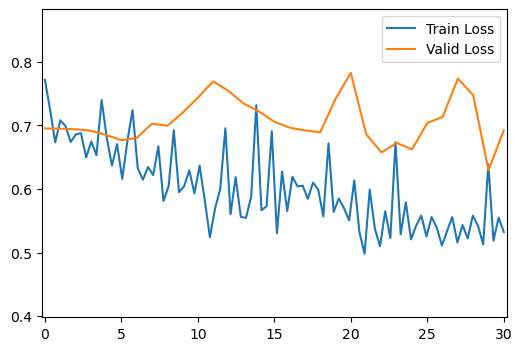

label: 0.0, output: 0.4803225100040436
label: 1.0, output: 0.47316405177116394
label: 1.0, output: 0.498094767332077
label: 0.0, output: 0.47040730714797974
label: 1.0, output: 0.48445820808410645
label: 1.0, output: 0.4914020299911499
label: 1.0, output: 0.4932961165904999
label: 0.0, output: 0.48572754859924316
label: 0.0, output: 0.4845234155654907
label: 1.0, output: 0.4617961347103119
label: 1.0, output: 0.4948808252811432
label: 0.0, output: 0.47706034779548645
label: 1.0, output: 0.4735622704029083
label: 0.0, output: 0.47100502252578735
label: 0.0, output: 0.48052501678466797
label: 1.0, output: 0.5089890956878662
label: 1.0, output: 0.47543859481811523
label: 0.0, output: 0.4934307038784027
label: 0.0, output: 0.46042579412460327
label: 1.0, output: 0.4441130459308624
label: 1.0, output: 0.5083475112915039
label: 0.0, output: 0.43080365657806396
label: 1.0, output: 0.4721222221851349
label: 1.0, output: 0.4905000925064087
label: 1.0, output: 0.4861874282360077
label: 0.0, outp

label: 0.0, output: 0.5484730005264282
label: 1.0, output: 0.06704778224229813
label: 1.0, output: 0.9443040490150452
label: 0.0, output: 0.31106090545654297
label: 1.0, output: 0.11344534158706665
label: 1.0, output: 0.942783534526825
label: 1.0, output: 0.3306804895401001
label: 0.0, output: 0.24516887962818146
label: 0.0, output: 0.8286237120628357
label: 1.0, output: 0.008150202222168446
label: 1.0, output: 0.925603985786438
label: 0.0, output: 0.37483882904052734
label: 1.0, output: 0.03653530403971672
label: 0.0, output: 0.41028353571891785
label: 0.0, output: 0.48160138726234436
label: 1.0, output: 0.9654124975204468
label: 1.0, output: 0.36548590660095215
label: 0.0, output: 0.9711843729019165
label: 0.0, output: 0.33910202980041504
label: 1.0, output: 0.019008703529834747
label: 1.0, output: 0.9407721161842346
label: 0.0, output: 0.2558906674385071
label: 1.0, output: 0.022245975211262703
label: 1.0, output: 0.9309715032577515
label: 1.0, output: 0.3442448079586029
label: 0.0,

label: 0.0, output: 0.1758575439453125
label: 1.0, output: 0.029244747012853622
label: 1.0, output: 0.9904516935348511
label: 0.0, output: 0.10889998823404312
label: 1.0, output: 0.005845444742590189
label: 1.0, output: 0.8983203768730164
label: 1.0, output: 0.38659635186195374
label: 0.0, output: 0.06325088441371918
label: 0.0, output: 0.876340925693512
label: 1.0, output: 0.0001283698802581057
label: 1.0, output: 0.6791966557502747
label: 0.0, output: 0.26169827580451965
label: 1.0, output: 0.02815939486026764
label: 0.0, output: 0.03557820990681648
label: 0.0, output: 0.9439266324043274
label: 1.0, output: 0.9864513874053955
label: 1.0, output: 0.04944141209125519
label: 0.0, output: 0.8802869319915771
label: 0.0, output: 0.8105978965759277
label: 1.0, output: 0.29036301374435425
label: 1.0, output: 0.9983090162277222
label: 0.0, output: 0.5996854901313782
label: 1.0, output: 0.22961202263832092
label: 1.0, output: 0.9797033667564392
label: 1.0, output: 0.5617038607597351
label: 0.0

In [63]:
num_epochs = 30

train_losses = []
valid_losses = []
accuracies = []

mb = master_bar(range(num_epochs))
mb.names = ["Train Loss", "Valid Loss"]
mb.main_bar.comment = f"Epochs"

vl, accuracy, _ = validate(None, val_loader, device, model, criterion)
valid_losses.extend(vl)
accuracies.append(accuracy)

for epoch in mb:

    tl = train_one_epoch(mb, train_loader, device, model, criterion, optimizer)
    train_losses.extend(tl)

    vl, accuracy, acc_by_class = validate(mb, val_loader, device, model, criterion)
    valid_losses.extend(vl)
    accuracies.append(accuracy)

    update_plots(mb, train_losses, valid_losses, epoch, num_epochs)

Accuracy per class
     Low Risk: 100.0%
    High Risk: 0.0%
Highest Accuracy: 66.7%
Final Accuracy: 44.4%


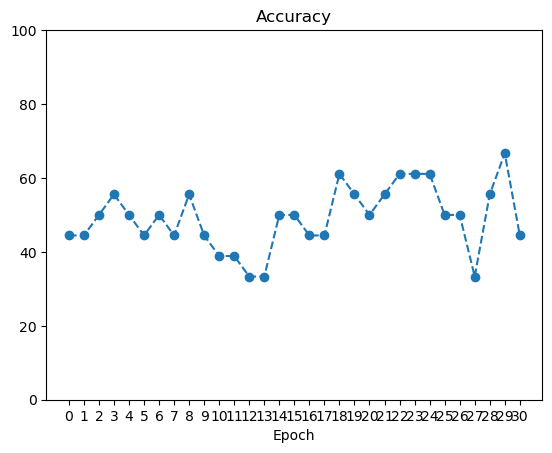

In [64]:
plt.plot(accuracies, '--o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.xticks(range(num_epochs+1))
plt.ylim([0, 100])

class_names = train_loader.dataset.classes
max_name_len = max(len(name) for name in class_names)

print("Accuracy per class")
for clss in acc_by_class:
    class_name = class_names[clss]
    class_accuracy = acc_by_class[clss]
    print(f"  {class_name:>{max_name_len+2}}: {class_accuracy:.1f}%")
print(f"Highest Accuracy: {max(accuracies):.1f}%")
print(f"Final Accuracy: {accuracies[-1]:.1f}%")

In [65]:
y_trues = []
y_preds = []
model.to(device)
for x, y in val_loader:
    y_trues.append(y.cpu())
    y_preds.append((model(x.to(device)) > class_threshold).cpu())


y_true = torch.hstack(y_trues)
y_pred = torch.hstack(y_preds)

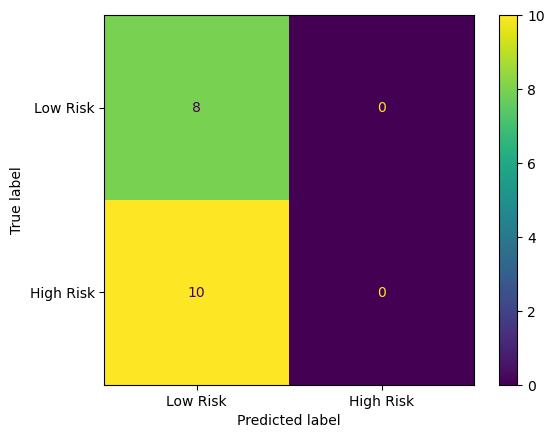

In [66]:
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot();